In [1]:
import numpy as np
import pandas as pd

In [2]:
train=pd.read_excel('/content/Data_Train.xlsx')

In [3]:
train.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [4]:
train.shape

(6237, 9)

#Preprocessing

In [5]:
train['Edition_1']=train['Edition'].str.split(',').str[0]
train['Reviews']=train['Reviews'].str.split().str[0]
train['Ratings']=train['Ratings'].str.replace(',','')
train['Ratings']=train['Ratings'].str.split().str[0]
train['Ratings']=train['Ratings'].astype('float')
train['Genre']=train['Genre'].str.replace(r'\((.*?)\)','')

In [6]:
train.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Edition_1
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0,8.0,THE HUNTERS return in their third brilliant no...,Action & Adventure,Action & Adventure,220.00,Paperback
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9,14.0,A layered portrait of a troubled genius for wh...,Cinema & Broadcast,"Biographies, Diaries & True Accounts",202.93,Paperback
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8,6.0,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1,13.0,A handful of grain is found in the pocket of a...,Contemporary Fiction,"Crime, Thriller & Mystery",180.00,Paperback
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0,1.0,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover


In [7]:
train['Edition_2']=train['Edition'].str.split(',').str[1]
train['Edition_2']=train['Edition_2'].str.replace('–','')

In [8]:
train['Edition_2']=pd.to_datetime(train['Edition_2'],errors='coerce')
train['Edition_year']=train['Edition_2'].dt.year

In [9]:
train.isna().sum()

Title             0
Author            0
Edition           0
Reviews           0
Ratings           0
Synopsis          0
Genre             0
BookCategory      0
Price             0
Edition_1         0
Edition_2       789
Edition_year    789
dtype: int64

In [10]:
train['Edition_year']=train['Edition_year'].fillna(train['Edition_year'].mode()[0])

In [11]:
train=train.drop('Edition_2',axis=1)

In [12]:
train=train.drop('Edition',axis=1)

In [13]:
train.head()

,Title,Author,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Edition_1,Edition_year
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,4.0,8.0,THE HUNTERS return in their third brilliant no...,Action & Adventure,Action & Adventure,220.00,Paperback,2016.0
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,3.9,14.0,A layered portrait of a troubled genius for wh...,Cinema & Broadcast,"Biographies, Diaries & True Accounts",202.93,Paperback,2012.0
2,Leviathan (Penguin Classics),Thomas Hobbes,4.8,6.0,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,1982.0
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,4.1,13.0,A handful of grain is found in the pocket of a...,Contemporary Fiction,"Crime, Thriller & Mystery",180.00,Paperback,2017.0
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,5.0,1.0,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,2006.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text major ticklabel objects>)

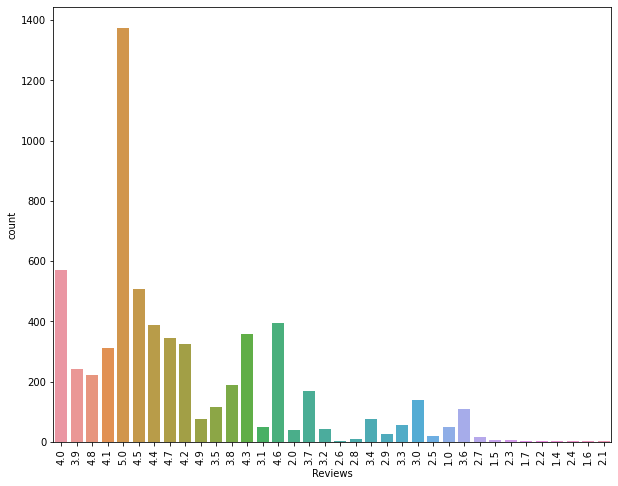

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.countplot(x='Reviews',data=train)
plt.xticks(rotation=90)

In [15]:
train['Reviews']=train['Reviews'].astype('float')

In [16]:
train.dtypes

Title            object
Author           object
Reviews         float64
Ratings         float64
Synopsis         object
Genre            object
BookCategory     object
Price           float64
Edition_1        object
Edition_year    float64
dtype: object

In [17]:
for col in train.select_dtypes(include='object'):
  train[col] = train[col].str.lower()

In [18]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import re
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
wnl=WordNetLemmatizer()
corpus=[]

In [20]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
for i in range(len(train)):
  review=re.sub('[^a-zA-Z]',' ',train['Synopsis'][i])
  review=review.lower()
  review=review.split()
  review=[wnl.lemmatize(word) for word in review if not word in stopwords.words('english')]
  review=' '.join(review)
  corpus.append(review)

In [22]:
train['new_synopsis']=corpus
train=train.drop('Synopsis',axis=1)

In [23]:
train.head()

,Title,Author,Reviews,Ratings,Genre,BookCategory,Price,Edition_1,Edition_year,new_synopsis
0,the prisoner's gold (the hunters 3),chris kuzneski,4.0,8.0,action & adventure,action & adventure,220.00,paperback,2016.0,hunter return third brilliant novel sunday tim...
1,guru dutt: a tragedy in three acts,arun khopkar,3.9,14.0,cinema & broadcast,"biographies, diaries & true accounts",202.93,paperback,2012.0,layered portrait troubled genius art merely th...
2,leviathan (penguin classics),thomas hobbes,4.8,6.0,international relations,humour,299.00,paperback,1982.0,time men live without common power keep awe co...
3,a pocket full of rye (miss marple),agatha christie,4.1,13.0,contemporary fiction,"crime, thriller & mystery",180.00,paperback,2017.0,handful grain found pocket murdered businessma...
4,life 70 years of extraordinary photography,editors of life,5.0,1.0,photography textbooks,"arts, film & photography",965.62,hardcover,2006.0,seven decade life thrilling world unrivalled p...


In [24]:
train['book_age']=2021-train['Edition_year']

In [25]:
def find_polarity(review):
  return TextBlob(review).sentiment

In [26]:
train['sentiment']=train['new_synopsis'].apply(find_polarity)

In [27]:
sentiment_series = train['sentiment'].tolist()
columns = ['polarity', 'subjectivity']

df = pd.DataFrame(sentiment_series, columns=columns, index=train.index)

train['polarity'] = df['polarity']
train['subjectivity'] = df['subjectivity']

In [28]:
from wordcloud import WordCloud

#Plot some positive book words

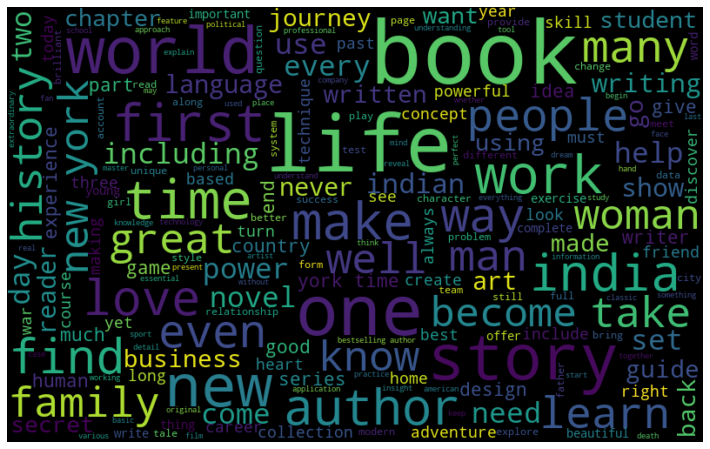

In [29]:
all_words = " ".join([sentence for sentence in train['new_synopsis'][train['polarity']>0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Plot some negative book words

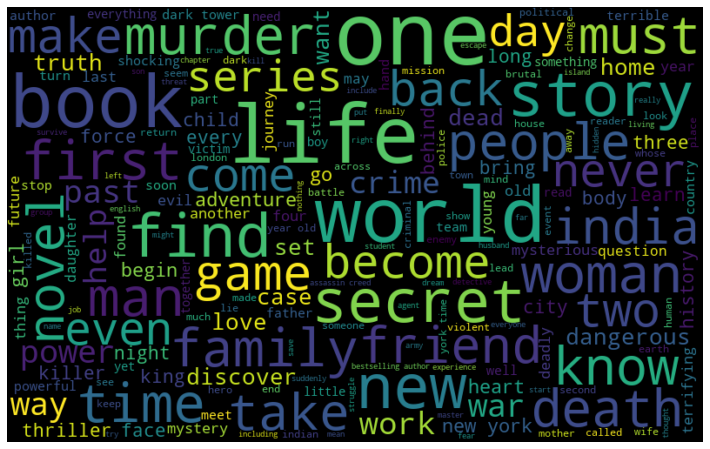

In [30]:
all_words = " ".join([sentence for sentence in train['new_synopsis'][train['polarity']<0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [31]:
train.head()

,Title,Author,Reviews,Ratings,Genre,BookCategory,Price,Edition_1,Edition_year,new_synopsis,book_age,sentiment,polarity,subjectivity
0,the prisoner's gold (the hunters 3),chris kuzneski,4.0,8.0,action & adventure,action & adventure,220.00,paperback,2016.0,hunter return third brilliant novel sunday tim...,5.0,"(0.20879953379953375, 0.45134032634032634)",0.208800,0.451340
1,guru dutt: a tragedy in three acts,arun khopkar,3.9,14.0,cinema & broadcast,"biographies, diaries & true accounts",202.93,paperback,2012.0,layered portrait troubled genius art merely th...,9.0,"(0.1473484848484848, 0.4911616161616162)",0.147348,0.491162
2,leviathan (penguin classics),thomas hobbes,4.8,6.0,international relations,humour,299.00,paperback,1982.0,time men live without common power keep awe co...,39.0,"(0.15149147727272727, 0.4214962121212121)",0.151491,0.421496
3,a pocket full of rye (miss marple),agatha christie,4.1,13.0,contemporary fiction,"crime, thriller & mystery",180.00,paperback,2017.0,handful grain found pocket murdered businessma...,4.0,"(0.1, 0.375)",0.100000,0.375000
4,life 70 years of extraordinary photography,editors of life,5.0,1.0,photography textbooks,"arts, film & photography",965.62,hardcover,2006.0,seven decade life thrilling world unrivalled p...,15.0,"(0.28888888888888886, 0.7861111111111111)",0.288889,0.786111


In [32]:
train.drop(['Title','sentiment'], axis = 1, inplace = True)

In [33]:
train.head()

,Author,Reviews,Ratings,Genre,BookCategory,Price,Edition_1,Edition_year,new_synopsis,book_age,polarity,subjectivity
0,chris kuzneski,4.0,8.0,action & adventure,action & adventure,220.00,paperback,2016.0,hunter return third brilliant novel sunday tim...,5.0,0.208800,0.451340
1,arun khopkar,3.9,14.0,cinema & broadcast,"biographies, diaries & true accounts",202.93,paperback,2012.0,layered portrait troubled genius art merely th...,9.0,0.147348,0.491162
2,thomas hobbes,4.8,6.0,international relations,humour,299.00,paperback,1982.0,time men live without common power keep awe co...,39.0,0.151491,0.421496
3,agatha christie,4.1,13.0,contemporary fiction,"crime, thriller & mystery",180.00,paperback,2017.0,handful grain found pocket murdered businessma...,4.0,0.100000,0.375000
4,editors of life,5.0,1.0,photography textbooks,"arts, film & photography",965.62,hardcover,2006.0,seven decade life thrilling world unrivalled p...,15.0,0.288889,0.786111


In [34]:
train['Author']=train['Author'].astype('category').cat.codes

In [35]:
train['Genre']=train['Genre'].astype('category').cat.codes

In [36]:
train['BookCategory']=train['BookCategory'].astype('category').cat.codes

In [37]:
train['Edition_1']=train['Edition_1'].astype('category').cat.codes

In [38]:
train['Edition_year']=train['Edition_year'].astype('category').cat.codes

In [39]:
train['book_age']=train['book_age'].astype('category').cat.codes

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
train=train.drop('new_synopsis',axis=1)

In [42]:
train.head()

,Author,Reviews,Ratings,Genre,BookCategory,Price,Edition_1,Edition_year,book_age,polarity,subjectivity
0,614,4.0,8.0,0,0,220.00,12,49,3,0.208800,0.451340
1,306,3.9,14.0,73,2,202.93,12,45,7,0.147348,0.491162
2,3384,4.8,6.0,192,6,299.00,12,15,37,0.151491,0.421496
3,59,4.1,13.0,91,5,180.00,12,50,2,0.100000,0.375000
4,949,5.0,1.0,253,1,965.62,7,39,13,0.288889,0.786111


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


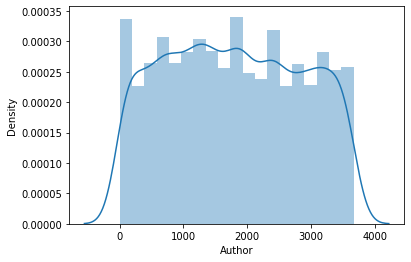

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


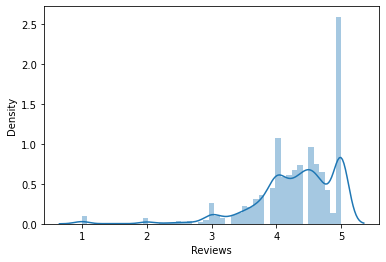

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


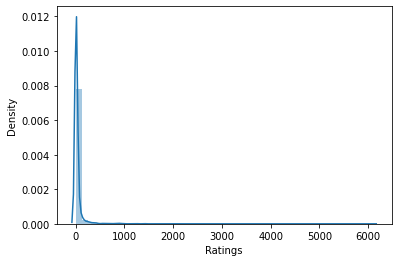

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


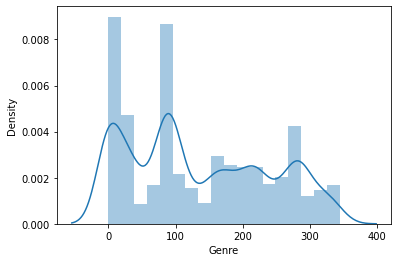

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


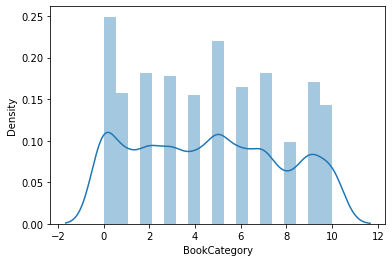

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


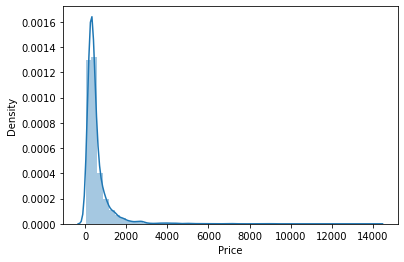

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


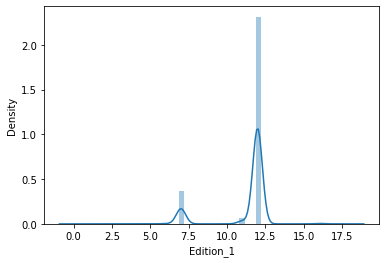

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


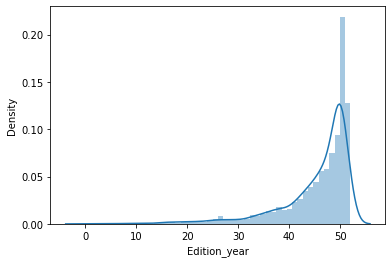

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


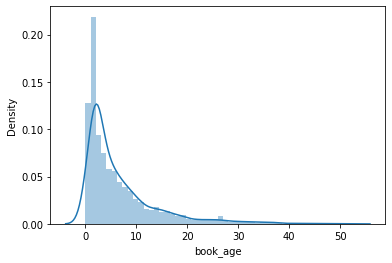

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


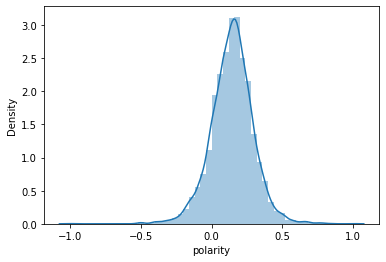

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


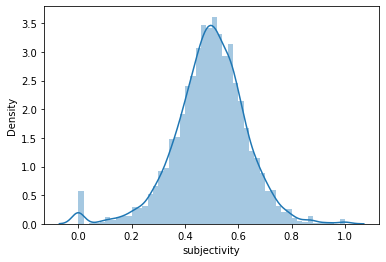

In [43]:
for i in train:
  sns.distplot(train[i])
  plt.show()

In [44]:
#X=train.drop('Price',axis=1)
#y=boxcox(train['Price'])

In [45]:
train_corr=train.corr()

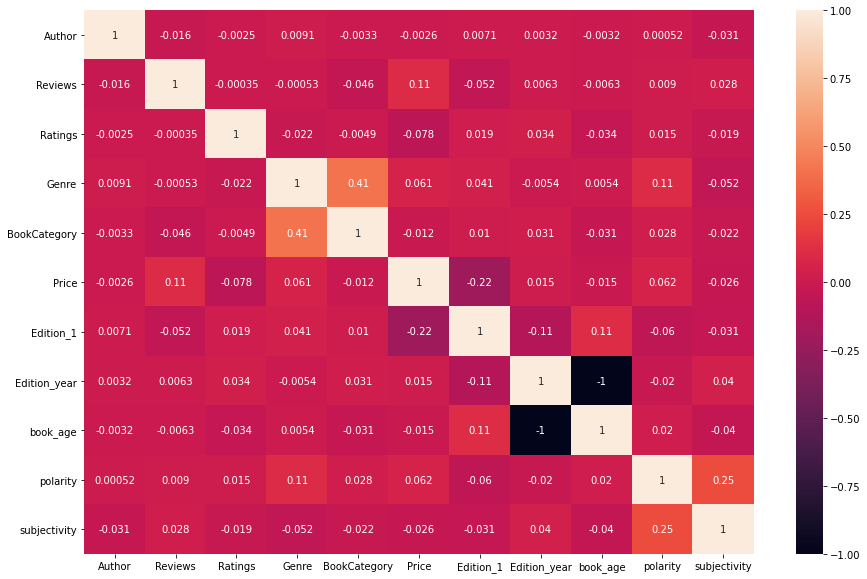

In [46]:
plt.figure(figsize=(15,10))
sns.heatmap(train_corr,annot=True)

### **So Edition_year and book_age are highly correlated to each other so i am going to drop one of them**

In [47]:
train=train.drop('book_age',axis=1)

In [48]:
X = train.drop('Price', axis =1)
y, param = boxcox(train.Price)

print('Optimal lambda', param)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20,random_state=1)

Optimal lambda -0.13820326756118104


In [49]:
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

#ML Model

In [50]:
rf=RandomForestRegressor(n_estimators=200)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [52]:
y_pred = rf.predict(X_val)
mse(y_val, y_pred)

0.07133387629031454

In [53]:
preds=pd.DataFrame(y_val)

In [54]:
preds['Model_preds']=y_pred

In [55]:
preds

,0,Model_preds
0,4.426086,3.833505
1,3.878685,3.848996
2,3.914661,4.028838
3,4.760640,4.288233
4,4.352093,4.412369
...,...,...
1243,3.810647,4.049218
1244,4.804806,4.493102
1245,3.833264,4.029825
1246,4.069009,4.077241
